## Imports


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model


In [21]:
df = pd.read_csv("../noisy_gait_synth_data.csv")  # adjust path if needed
df.head()


,participant_id,time,group,walking_speed,sEMG_TA,sEMG_GM,sEMG_VL,sEMG_BF,sEMG_RF,ground_reaction_force
0,0,0.00000,SCI,0.490452,-0.055306,-0.232351,-0.210068,-0.281338,-0.155990,-28.830657
1,0,0.02004,SCI,0.489716,0.040567,0.482264,-0.382254,0.560597,0.159099,28.122569
2,0,0.04008,SCI,0.488981,0.694355,0.015144,0.675682,-0.288256,0.769657,49.855244
3,0,0.06012,SCI,0.488245,0.594982,0.291594,0.363988,0.028906,0.806068,159.872365
4,0,0.08016,SCI,0.487509,0.790292,0.470375,0.202701,0.484268,0.488469,192.164023


## SCI Predictor

In [22]:
emg_cols = [col for col in df.columns if col.startswith("sEMG_")]
all_features = emg_cols + ["ground_reaction_force"]

# Encode SCI=1, Normal=0
df['group_encoded'] = LabelEncoder().fit_transform(df['group'])

# Normalize sEMG + GRF features
scaler = StandardScaler()
df[all_features] = scaler.fit_transform(df[all_features])


In [23]:
sequence_length = 50
step_size = 25

X, y = [], []

for pid in df['participant_id'].unique():
    df_p = df[df['participant_id'] == pid]
    features = df_p[all_features].values
    label = df_p['group_encoded'].iloc[0]

    for i in range(0, len(features) - sequence_length + 1, step_size):
        X.append(features[i:i + sequence_length])
        y.append(label)

X = np.array(X)
y = np.array(y)

X.shape, y.shape  # Check output shape


((950, 50, 6), (950,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [25]:
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\Natha\miniconda3\envs\emg_rnn_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.7500 - loss: 0.5979 - val_accuracy: 1.0000 - val_loss: 0.1233
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9989 - loss: 0.0717 - val_accuracy: 1.0000 - val_loss: 0.0157
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0144 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - v

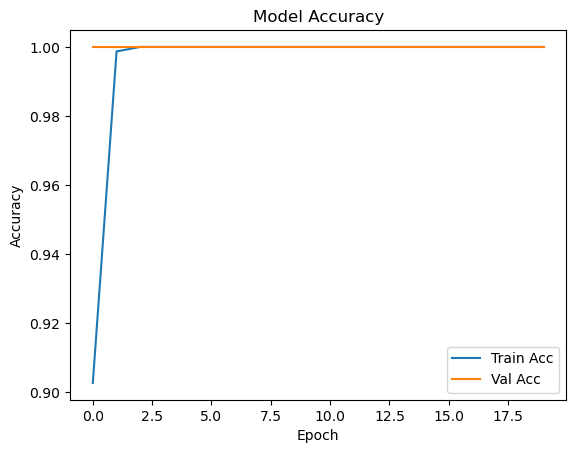

In [27]:
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [28]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.2f}")


Test Accuracy: 1.00


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


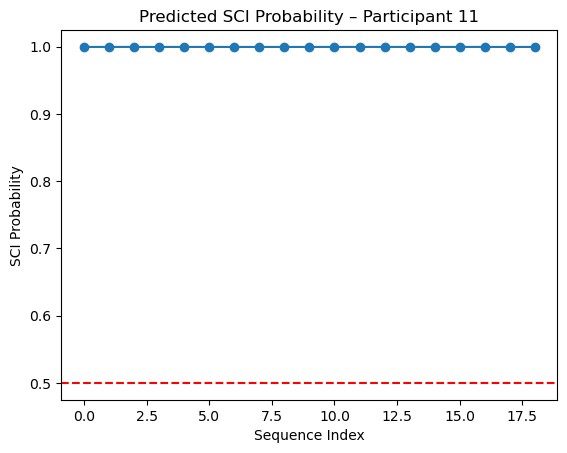

In [32]:
# Pick a random participant from the test set
test_pids = df[df['participant_id'].isin(df['participant_id'].unique())].groupby('participant_id').first()
test_pid = test_pids.sample(1).index.item()

# Extract sequences for that participant
df_p = df[df['participant_id'] == test_pid]
features = df_p[all_features].values
features = StandardScaler().fit_transform(features)  # ensure normalized

sequences = []
for i in range(0, len(features) - sequence_length + 1, step_size):
    sequences.append(features[i:i + sequence_length])
sequences = np.array(sequences)

# Predict
pred_probs = model.predict(sequences).flatten()
pred_labels = (pred_probs > 0.5).astype(int)

# Plot predictions over time
plt.plot(pred_probs, marker='o')
plt.axhline(0.5, linestyle='--', color='red')
plt.title(f"Predicted SCI Probability – Participant {test_pid}")
plt.xlabel("Sequence Index")
plt.ylabel("SCI Probability")
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 


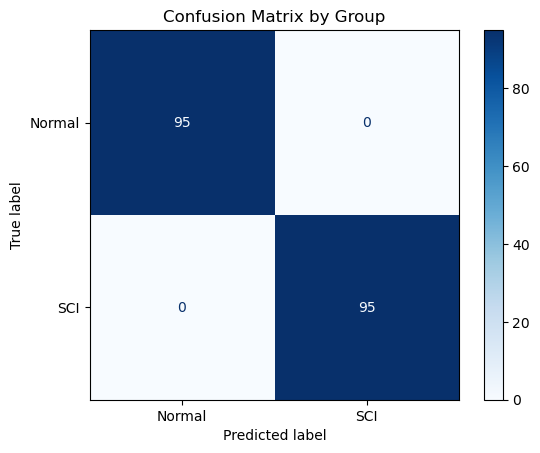

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "SCI"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix by Group")
plt.show()


In [31]:
# Reconstruct which test sequences belonged to which participant
# This assumes you still have df and participant info mapped to X/y
participant_ids = []

# Rebuild the index mapping by sequence from the original sliding window logic
for pid in df['participant_id'].unique():
    df_p = df[df['participant_id'] == pid]
    n_seq = (len(df_p) - sequence_length) // step_size + 1
    participant_ids.extend([pid] * n_seq)

# Keep only the test-set ones
_, X_test_pids = train_test_split(participant_ids, test_size=0.2, stratify=y, random_state=42)

# Compare predictions with true labels
for pid, true, pred in zip(X_test_pids, y_test, y_pred):
    if true != pred:
        print(f"❌ Misclassified participant {pid} | True: {true} → Predicted: {pred}")


## LSTM Generalization

In [63]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the dataset
df = pd.read_csv("../noisy_gait_synth_data.csv")  # Update path if needed

# Features
emg_cols = [col for col in df.columns if col.startswith("sEMG_")]
all_features = emg_cols + ["ground_reaction_force"]

# Encode labels
df["group_encoded"] = LabelEncoder().fit_transform(df["group"])  # SCI=1, Normal=0

# Normalize
scaler = StandardScaler()
df[all_features] = scaler.fit_transform(df[all_features])


In [64]:
sequence_length = 50
step_size = 25

def create_sequences(df, label):
    X, y = [], []
    for pid in df[df["group"] == label]["participant_id"].unique():
        df_p = df[df["group"] == label][df["participant_id"] == pid]
        X_p = df_p[all_features].values
        y_val = df_p["group_encoded"].iloc[0]
        for i in range(0, len(X_p) - sequence_length + 1, step_size):
            X.append(X_p[i:i + sequence_length])
            y.append(y_val)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(df, label="Normal")
X_test, y_test = create_sequences(df, label="SCI")
X_train.shape, X_test.shape


C:\Users\Natha\AppData\Local\Temp\ipykernel_18396\1692866177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_p = df[df["group"] == label][df["participant_id"] == pid]
C:\Users\Natha\AppData\Local\Temp\ipykernel_18396\1692866177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_p = df[df["group"] == label][df["participant_id"] == pid]
C:\Users\Natha\AppData\Local\Temp\ipykernel_18396\1692866177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_p = df[df["group"] == label][df["participant_id"] == pid]
C:\Users\Natha\AppData\Local\Temp\ipykernel_18396\1692866177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_p = df[df["group"] == label][df["participant_id"] == pid]
C:\Users\Natha\AppData\Local\Temp\ipykernel_18396\1692866177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_p = df[df["group"] == label]

((475, 50, 6), (475, 50, 6))

In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the dataset
df = pd.read_csv("../noisy_gait_synth_data.csv")  # Update path if needed

# Features
emg_cols = [col for col in df.columns if col.startswith("sEMG_")]
all_features = emg_cols + ["ground_reaction_force"]

# Encode labels
df["group_encoded"] = LabelEncoder().fit_transform(df["group"])  # SCI=1, Normal=0

# Normalize
scaler = StandardScaler()
df[all_features] = scaler.fit_transform(df[all_features])


In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed

timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# Encoder
input_seq = Input(shape=(timesteps, n_features), name="input_seq")
encoded = LSTM(64, name="encoder_lstm")(input_seq)
repeated = RepeatVector(timesteps)(encoded)

# Decoder
decoded = LSTM(64, return_sequences=True)(repeated)
output_seq = TimeDistributed(Dense(n_features))(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_seq, outputs=output_seq)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train only on Normal gait data
autoencoder.fit(X_test, X_test, epochs=5, batch_size=32)



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_seq (InputLayer)          │ (None, 50, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm (LSTM)             │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 50, 6)          │           390 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,590 (201.52 KB)

 Trainable params: 51,590 (201.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.9645
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.9392
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.9413
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.9341
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.9227


In [67]:
encoder = Model(inputs=input_seq, outputs=encoded)
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


## DAAE Autoencoder

In [72]:
import tensorflow as tf

@tf.custom_gradient
def reverse_gradient(x):
    def grad(dy):
        return -dy
    return x, grad

class GradientReversal(tf.keras.layers.Layer):
    def call(self, x):
        return reverse_gradient(x)


In [73]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout

timesteps = X_train.shape[1]
n_features = X_train.shape[2]
latent_dim = 64

# --- Encoder ---
input_seq = Input(shape=(timesteps, n_features), name="input_seq")
encoded = LSTM(latent_dim, name="encoder_lstm")(input_seq)

# --- Decoder (reconstruction branch) ---
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(latent_dim, return_sequences=True)(decoded)
reconstruction = TimeDistributed(Dense(n_features), name="reconstruction")(decoded)

# --- Domain Classifier (adversarial branch) ---
grl = GradientReversal()(encoded)
domain_pred = Dense(32, activation='relu')(grl)
domain_pred = Dropout(0.3)(domain_pred)
domain_output = Dense(1, activation='sigmoid', name="domain_output")(domain_pred)

# --- Combined Model ---
daae = Model(inputs=input_seq, outputs=[reconstruction, domain_output])
daae.compile(
    optimizer='adam',
    loss={'reconstruction': 'mse', 'domain_output': 'binary_crossentropy'},
    loss_weights={'reconstruction': 1.0, 'domain_output': 0.2},
    metrics={'domain_output': 'accuracy'}
)
daae.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_seq           │ (None, 50, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ (None, 64)        │     18,176 │ input_seq[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gradient_reversal_1 │ (None, 64)        │          0 │ encoder_lstm[0][… │
│ (GradientReversal)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 50, 64)    │          0 │ encoder_lstm[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ gradient_reversa… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 50, 64)    │     33,024 │ repeat_vector_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reconstruction      │ (None, 50, 6)     │        390 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ domain_output       │ (None, 1)         │         33 │ dropout_6[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,703 (209.78 KB)

 Trainable params: 53,703 (209.78 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Combine Normal and SCI data
X_combined = np.concatenate([X_train, X_test])
y_domain = np.concatenate([
    np.zeros(len(X_train)),  # Normal = 0
    np.ones(len(X_test))     # SCI = 1
])


In [75]:
# Unsupervised: targets = inputs (reconstruction), domain = 0/1
daae.fit(
    X_combined,
    {'reconstruction': X_combined, 'domain_output': y_domain},
    epochs=30,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - domain_output_accuracy: 0.5131 - domain_output_loss: 0.6980 - loss: 1.1164 - reconstruction_loss: 0.9768 - val_domain_output_accuracy: 0.0105 - val_domain_output_loss: 0.7720 - val_loss: 1.1099 - val_reconstruction_loss: 0.9556
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - domain_output_accuracy: 0.1991 - domain_output_loss: 0.7707 - loss: 1.1036 - reconstruction_loss: 0.9495 - val_domain_output_accuracy: 0.0000e+00 - val_domain_output_loss: 1.0932 - val_loss: 1.1772 - val_reconstruction_loss: 0.9587
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - domain_output_accuracy: 0.1318 - domain_output_loss: 0.9202 - loss: 1.1201 - reconstruction_loss: 0.9360 - val_domain_output_accuracy: 0.0000e+00 - val_domain_output_loss: 0.8695 - val_loss: 1.1330 - val_reconstruction_loss: 0.9593
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - domain_output_accuracy: 0.1658 - domain_output_loss: 0.8263 - loss: 1.0322 - reconstruction_lo

In [83]:
encoder_only = Model(inputs=input_seq, outputs=encoded)
X_train_latent = encoder_only.predict(X_train)
X_test_latent = encoder_only.predict(X_test)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


## T-SNE, PCA, CORAL, Regressor Metrics

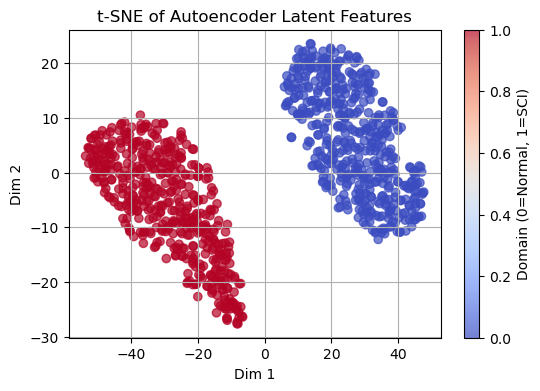

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Combine latent vectors
X_latent_all = np.concatenate([X_train_latent, X_test_latent], axis=0)
y_all_domain = np.array([0]*len(X_train_latent) + [1]*len(X_test_latent))  # 0=Normal, 1=SCI

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_latent_all)

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_all_domain, cmap='coolwarm', alpha=0.7)
plt.title("t-SNE of Autoencoder Latent Features")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label="Domain (0=Normal, 1=SCI)")
plt.grid(True)
plt.show()


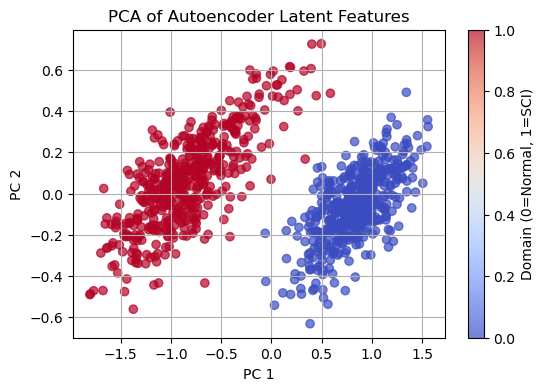

In [ ]:
from sklearn.decomposition import PCA

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_latent_all)

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_all_domain, cmap='coolwarm', alpha=0.7)
plt.title("PCA of Autoencoder Latent Features")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label="Domain (0=Normal, 1=SCI)")
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf

def coral_loss(source, target):
    d = tf.cast(tf.shape(source)[1], tf.float32)
    xm = source - tf.reduce_mean(source, axis=0, keepdims=True)
    xc = tf.matmul(tf.transpose(xm), xm)

    ym = target - tf.reduce_mean(target, axis=0, keepdims=True)
    yc = tf.matmul(tf.transpose(ym), ym)

    return tf.reduce_sum(tf.square(xc - yc)) / (4 * d * d)

coral_score = coral_loss(
    tf.convert_to_tensor(X_train_latent, dtype=tf.float32),
    tf.convert_to_tensor(X_test_latent, dtype=tf.float32)
).numpy()

print(f"CORAL Distance (Normal → SCI latent space): {coral_score:.4f}")


CORAL Distance (Normal → SCI latent space): 0.4192


In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Generate walking speed sequence averages
def extract_avg_speed(df, label, seq_len=50, step=25):
    speeds = []
    for pid in df[df["group"] == label]["participant_id"].unique():
        df_p = df[(df["participant_id"] == pid) & (df["group"] == label)]
        speed_seq = df_p["walking_speed"].values
        for i in range(0, len(speed_seq) - seq_len + 1, step):
            speeds.append(np.mean(speed_seq[i:i+seq_len]))
    return np.array(speeds)

# Labels
y_train_speed = extract_avg_speed(df, "Normal")
y_test_speed = extract_avg_speed(df, "SCI")

# Fit regressor on Normal latent space
reg = LinearRegression()
reg.fit(X_train_latent, y_train_speed)

# Predict SCI walking speed from latent space
y_pred_speed = reg.predict(X_test_latent)

# Evaluate
mse = mean_squared_error(y_test_speed, y_pred_speed)
r2 = r2_score(y_test_speed, y_pred_speed)

print(f"MSE on SCI walking speed: {mse:.4f}")
print(f"R² on SCI walking speed: {r2:.4f}")


MSE on SCI walking speed: 7.4879
R² on SCI walking speed: -412.7758
